In [3]:
# Importamos librerias a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [4]:
# Cargamos el dataset
df = pd.read_csv(r"C:\Users\ASUS\Desktop\CFBPredic\tables\CFB_limpio.csv")
# Aeguramos el formato fecha y orden
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

In [5]:
# Separamos solo la serie target/objetivo
y = df["cfb_cost"]

## Implementamos AUTO-ARIMA
### Funcionamiento: **Selecciona automaticamente p,d,q,P,D,Q**

In [6]:
print("\nEntrenando modelo Auto-ARIMA, por favor espera...\n")

modelo_auto = auto_arima(
    y,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12,                    # estacionalidad mensual
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

print("\n=== Mejor modelo encontrado por Auto-ARIMA ===")
print(modelo_auto.summary())


Entrenando modelo Auto-ARIMA, por favor espera...

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3245.927, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3262.834, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3258.306, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3255.301, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3263.669, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3246.988, Time=0.25 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.877, Time=0.34 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3248.728, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3253.698, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3256.662, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3244.787, Time=0.14 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=3245.559, Time=0.40 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : 

## Ajutamos el modelo SARIMA FINAL

In [7]:
order = modelo_auto.order
seasonal_order = modelo_auto.seasonal_order

print("\nUsando order=", order, " seasonal_order=", seasonal_order)

modelo = SARIMAX(
    y,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print("\n=== Resumen del modelo SARIMA final ===")
print(modelo.summary())


Usando order= (0, 1, 2)  seasonal_order= (0, 0, 0, 12)

=== Resumen del modelo SARIMA final ===
                               SARIMAX Results                                
Dep. Variable:               cfb_cost   No. Observations:                  417
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1490.867
Date:                Tue, 18 Nov 2025   AIC                           2987.734
Time:                        02:32:14   BIC                           2999.804
Sample:                             0   HQIC                          2992.508
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0736      0.018      4.042      0.000       0.038       0.109
ma.L2         -0.1447      0.023  

## Realizamos la predicción a Futuro

In [8]:
horizonte = 6  # meses futuros
pred = modelo.get_forecast(steps=horizonte)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Construir fechas futuras
fechas_futuras = pd.date_range(
    start=df["date"].iloc[-1] + pd.offsets.MonthBegin(1),
    periods=horizonte,
    freq="MS"
)

df_pred = pd.DataFrame({
    "date": fechas_futuras,
    "sarima_pred": pred_mean.values,
    "lower_ci": pred_ci.iloc[:,0].values,
    "upper_ci": pred_ci.iloc[:,1].values
})

print("\n=== Pronóstico SARIMA ===")
print(df_pred)


=== Pronóstico SARIMA ===
        date  sarima_pred    lower_ci    upper_ci
0 2025-10-01   820.257271  802.729199  837.785343
1 2025-11-01   819.347419  793.629976  845.064863
2 2025-12-01   819.347419  788.908678  849.786161
3 2026-01-01   819.347419  784.827178  853.867661
4 2026-02-01   819.347419  781.179669  857.515170
5 2026-03-01   819.347419  777.851549  860.843290


## Graficamos las predicciones

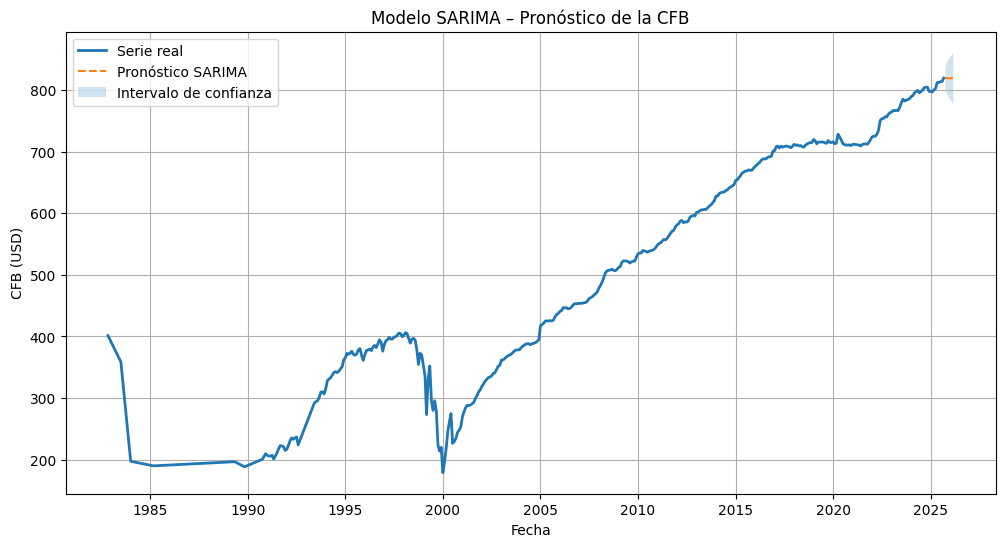

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df["date"], y, label="Serie real", linewidth=2)

# Predicción
plt.plot(df_pred["date"], df_pred["sarima_pred"],
         label="Pronóstico SARIMA", linestyle="--")

# Intervalos
plt.fill_between(df_pred["date"],
                 df_pred["lower_ci"],
                 df_pred["upper_ci"],
                 alpha=0.2, label="Intervalo de confianza")

plt.title("Modelo SARIMA – Pronóstico de la CFB")
plt.xlabel("Fecha")
plt.ylabel("CFB (USD)")
plt.legend()
plt.grid(True)
plt.show()

# GRAFICAR PREDICCIÓN SARIMA – (ULTIMOS 12 MESES)

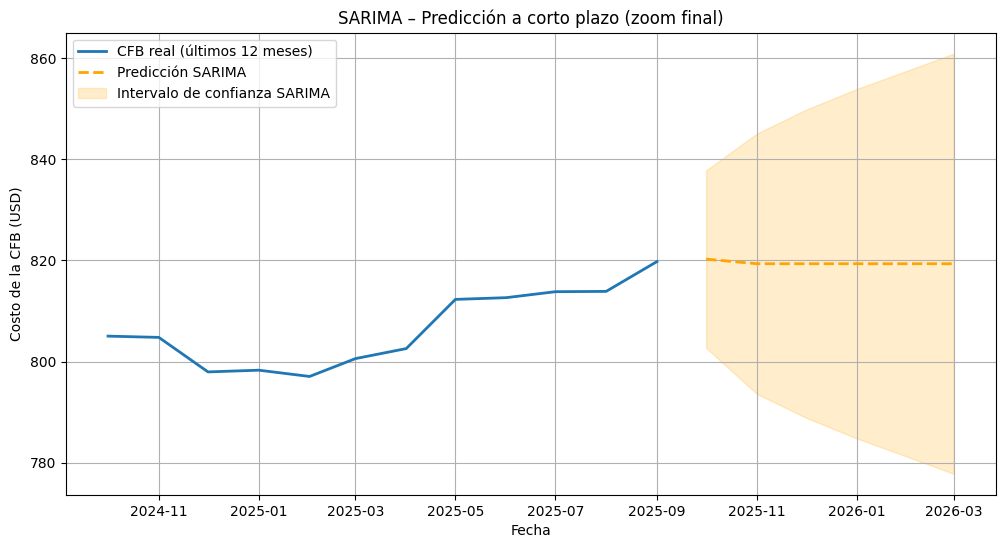

In [ ]:
# Tomar últimos 12 meses reales
n_ultimos = 12
df_zoom = df.tail(n_ultimos)

plt.figure(figsize=(12,6))

# Serie real (últimos 12 meses)
plt.plot(df_zoom["date"], df_zoom["cfb_cost"], 
         label="CFB real (últimos 12 meses)", linewidth=2)

# Predicciones SARIMA
plt.plot(df_pred["date"], df_pred["sarima_pred"],
         linestyle="--", label="Predicción SARIMA", linewidth=2, color="orange")

# Intervalo de confianza
plt.fill_between(df_pred["date"],
                 df_pred["lower_ci"],
                 df_pred["upper_ci"],
                 alpha=0.2, label="Intervalo de confianza SARIMA", color="orange")

plt.title("SARIMA – Predicción a corto plazo (zoom final)")
plt.xlabel("Fecha")
plt.ylabel("Costo de la CFB (USD)")
plt.grid(True)
plt.legend()
plt.show()